# Finansta Monte Carlo Simulasyonları

Monte Carlo simülasyonları, olasılıksal bir yorumu olan sorunları çözmek için tekrarlanan rastgele örnekleme kullanan bir hesaplama algoritmaları sınıfıdır. Finansta, popülerlik kazanmalarının nedenlerinden biri, integralleri doğru bir şekilde tahmin etmek için kullanılabilmeleridir. Monte Carlo simülasyonlarının ana fikri, genellikle belirli bir zaman dilimi içinde çok sayıda örnek yol üretmektir - olası senaryolar / sonuçlar. Ufuk daha sonra belirli sayıda zaman adımına bölünür ve bunu yapma sürecine ayrıklaştırma denir. Finansal araçların fiyatlandırması sürekli zamanda gerçekleştiğinden hedefi sürekli süreyi yaklaşık olarak belirlemektir.

Tüm bu simüle edilmiş örnek yollarından elde edilen sonuçlar, bir olayın gerçekleşme yüzdesi, son adımda bir aletin ortalama değeri vb. Gibi metrikleri hesaplamak için kullanılabilir. Tarihsel olarak, Monte Carlo yaklaşımı ile ilgili temel sorun, olası tüm senaryoları hesaplamak için ağır hesaplama gücüne ihtiyaç duymasıydı. Günümüzde, bir masaüstü bilgisayarda veya dizüstü bilgisayarda oldukça gelişmiş simülasyonlar çalıştırabildiğimiz için sorun daha az hale geliyor.

Bu bölümün sonunda Monte Carlo yöntemlerini çeşitli senaryolarda ve görevlerde nasıl kullanabileceğimizi göreceğiz. Bazılarında, simülasyonları sıfırdan yaratacağız, bazılarında ise süreci daha da kolaylaştırmak için modern Python kütüphanelerini kullanacağız. Yöntemin esnekliği nedeniyle Monte Carlo, hesaplama finansmanında en önemli tekniklerden biridir. Kapalı form çözümü olmayan fiyatlandırma türevleri (Amerikan / Egzotik opsiyonlar), tahvillerin değerlenmesi (örneğin, sıfır kuponlu bir tahvil), bir portföyün belirsizliğini tahmin etme (örneğin, hesaplayarak) gibi çeşitli sorunlara uyarlanabilir. Riske Maruz Değer ve Beklenen Eksiklik) veya risk yönetiminde stres testleri yapmak. Bu bölümde bu sorunların bazılarının nasıl çözüleceğini göstereceğiz.

# 1.Geometrik Brownian Hareketi kullanarak hisse senedi fiyatı dinamiklerini simüle etme

Finansal piyasaların öngörülemezliği sayesinde hisse senedi fiyatlarının simülasyonu, opsiyonlar gibi birçok türevin değerlemesinde önemli bir rol oynamaktadır. Fiyat hareketinde yukarıda belirtilen rasgelelik nedeniyle, bu simülasyonlar stokastik diferansiyel denklemlere (SDE) dayanmaktadır.

Stokastik bir sürecin, aşağıdaki SDE'yi karşıladığında Geometrik Brownian Hareketini (GBM) izlediği söylenir:

$$d S=\mu S d t+\sigma S d W_{t}$$

Burada aşağıdakiler var:
* S: Hisse fiyatı
* μ: Kayma katsayısı, yani belirli bir dönemdeki ortalama getiri veya anlık beklenen getiri
* σ: Difüzyon katsayısı, yani sapmada ne kadar oynaklık olduğu
* $W_{t}$: Brownian Hareketi

Brownian Hareketi'nin özelliklerini bu kitabın kapsamı dışında olduğu için çok derinlemesine araştırmayacağız. Söylemek yeterli, Brownian artışları bir Standart Normal rasgele değişkenin (rv-N (0,1)) ve zaman artışının kare kökünün bir ürünü olarak hesaplanır. Bunu söylemenin başka bir yolu, Brownian artışının rv ∼ N (0, t) 'den gelmesidir, burada t zaman artışıdır. Brownian yolunu, Brownian artışlarının kümülatif toplamını alarak elde ederiz.

SDE'de kapalı form çözümü vardır (yalnızca birkaç SDE'de vardır):

$$S(t)=S_{0} e^{\left(\mu-\frac{1}{2} \sigma^{2}\right) t+\sigma W_{t}}$$

Burada $S(t)=S_{0}$, sürecin başlangıç değeri olup, bu durumda bir hisse senedinin başlangıç fiyatıdır. Önceki denklem, ilk hisse senedi fiyatına kıyasla ilişkiyi sunar. 

Simülasyonlar için aşağıdaki özyinelemeli formülü kullanabiliriz:

$$S\left(t_{i+1}\right)=S\left(t_{i}\right) \exp \left(\mu-\frac{1}{2} \sigma^{2}\right)\left(t_{i+1}-t_{i}\right)+\sigma \sqrt{t_{i+1}-t_{i}} Z_{i+1}$$

Burada, $Z_{i}$ bir Standart Normal rasgele değişkendir ve $i=0, \ldots, T-1$ zaman indeksidir. Bu spesifikasyon mümkündür, çünkü W'nin artışları bağımsızdır ve normal olarak dağıtılır.

GBM, ortalama geri dönüş ve zamana bağlı oynaklığı hesaba katmayan bir süreçtir. Bu nedenle, nominal değere uzun vadeli tersine dönme eğilimi gösteren tahvil fiyatları için değil, genellikle hisse senetleri için kullanılır.

Burada, Microsoft'un hisse senedi fiyatlarını bir ay önceden simüle etmek için Monte Carlo yöntemlerini ve Geometrik Brownian Hareketini kullanıyoruz.

Kütüphanelerin çağırılması:

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf

Veriyi almak için parametreler:

In [3]:
RISKY_ASSET = 'MSFT'
START_DATE = '2019-01-01'
END_DATE = '2019-07-31'

Verinin indirilmesi:

In [4]:
df = yf.download(RISKY_ASSET, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  1 of 1 completed
Downloaded 146 rows of data.


Günlük getirilerin hesaplanması:

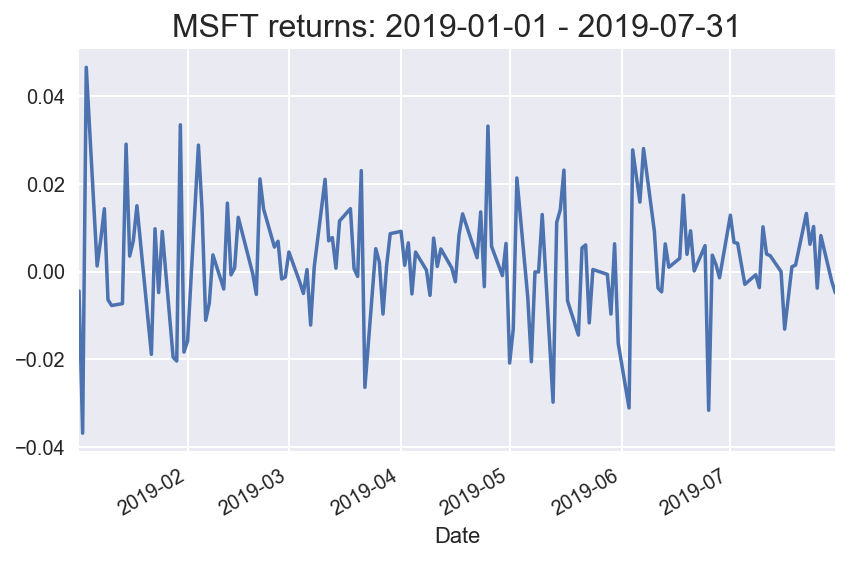

Average return: 0.24%


In [6]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()

ax = returns.plot()
ax.set_title(f'{RISKY_ASSET} returns: {START_DATE} - {END_DATE}', 
             fontsize=16)

plt.tight_layout()
#plt.savefig('images/ch6_im1.png')
plt.show()

print(f'Average return: {100 * returns.mean():.2f}%')

Verinin eğitim ve test verisi olarak bölünmesi:

In [7]:
train = returns['2019-01-01':'2019-06-30']
test = returns['2019-07-01':'2019-07-31']

Simülasyon parametrleri:

In [8]:
T = len(test)
N = len(test)
S_0 = adj_close[train.index[-1].date()]
N_SIM = 100
mu = train.mean()
sigma = train.std()

Simülasyon için kullanılacak fonksiyon:

In [9]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    np.random.seed(random_seed)
    
    dt = T/N
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis=1)
    
    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))
    
    S_t = s_0 * np.exp((mu - 0.5 * sigma**2) * time_steps 
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)
    
    return S_t

Simülasyonun çalıştırılması:

In [11]:
gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

Simülasyon sonuçlarının çizdirilmesi:

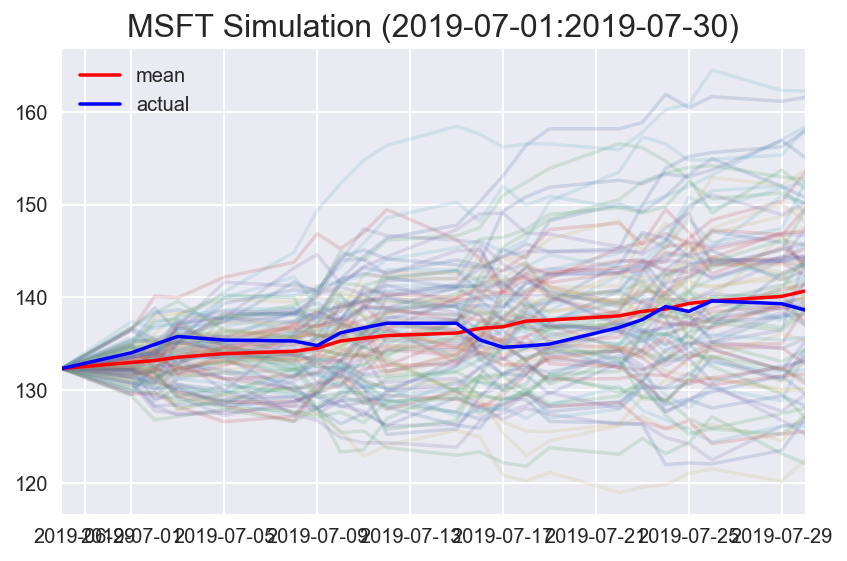

In [12]:
# prepare objects for plotting 
last_train_date = train.index[-1].date()
first_test_date = test.index[0].date()
last_test_date = test.index[-1].date()
plot_title = (f'{RISKY_ASSET} Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
#plt.savefig('images/ch6_im2.png')
plt.show()

Yukarıdaki grafikte, simülasyonlardan elde edilen ortalama değerin, pozitif sapma terimi nedeniyle pozitif bir eğilim sergilediğini gözlemliyoruz.

Bu görselleştirmenin yalnızca makul sayıda örnek yol için mümkün olduğunu unutmayın. Gerçek hayattaki durumlarda, 100'den çok daha fazla örnek yolu kullanmak istiyoruz, çünkü genellikle daha fazla örnek yolu, sonuçlar daha doğru / güvenilirdir.

Monte Carlo simülasyonları ile çalışmayı kolaylaştıran bazı istatistiksel yöntemler vardır (daha yüksek doğruluk, daha hızlı hesaplamalar). Bunlardan biri, **antitetik varyasyonlar** olarak adlandırılan bir varyans azaltma yöntemidir. Bu yaklaşımda, rastgele çekiliş çiftleri arasında negatif bağımlılık getirerek tahmin edicinin varyansını azaltmaya çalışıyoruz. Bu, aşağıdakilere dönüşür: örnek yollar oluştururken, her $\left[\epsilon_{1}, \ldots, \epsilon_{t}\right]$ için, aynı zamanda $\left[-\epsilon_{1}, \ldots,-\epsilon_{t}\right]$ antitetik değerlerini de alırız.

Bu yaklaşımın avantajları:
* N yolu oluşturmak için çizilecek Standart Normal numune sayısında (yarı yarıya) azalma
* Örnek yolu varyansının azaltılması, aynı zamanda doğruluğun artırılması

Bu yaklaşımı `simulate_gbm` fonksiyonunda uyguladık. Ayrıca, hesaplamaların çoğunu tek bir satıra koyarak fonksiyonu kısalttık.

Bu değişiklikleri uygulamadan önce, işlevin eski sürümünü zamanladık:

In [13]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

188 µs ± 3.44 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Yeni fonksiyon:

In [14]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, random_seed=42, antithetic_var=False):
    '''
    Function used for simulating stock returns using Geometric Brownian Motion.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    mu : float
        Drift coefficient
    sigma : float
        Diffusion coefficient
    n_sims : int
        Number of simulations paths
    dt : float
        Time increment, most commonly a day
    T : float
        Length of the forecast horizon, same unit as dt
    N : int
        Number of time increments in the forecast horizon
    random_seed : int
        Random seed for reproducibility
    antithetic_var : bool
        Boolean whether to use antithetic variates approach to reduce variance

    Returns
    -----------
    S_t : np.ndarray
        Matrix (size: n_sims x (T+1)) containing the simulation results. 
        Rows respresent sample paths, while columns point of time.
    '''
    
    np.random.seed(random_seed)
    
    # time increment
    dt = T/N
    
    # Brownian
    if antithetic_var:
        dW_ant = np.random.normal(scale = np.sqrt(dt), 
                                  size=(int(n_sims/2), N + 1))
        dW = np.concatenate((dW_ant, -dW_ant), axis=0)
    else: 
        dW = np.random.normal(scale = np.sqrt(dt), 
                              size=(n_sims, N + 1))
  
    # simulate the evolution of the process
    S_t = s_0 * np.exp(np.cumsum((mu - 0.5 * sigma ** 2) * dt + sigma * dW, 
                                 axis=1)) 
    S_t[:, 0] = s_0
    
    return S_t

İlk olarak antitetik değişkenler olmadan simülasyonu yapalım:

In [15]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N)

106 µs ± 871 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Şimdi de antitetik değişkenleri ekleyelim:

In [16]:
%timeit gbm_simulations = simulate_gbm(S_0, mu, sigma, N_SIM, T, N, antithetic_var=True)

80.5 µs ± 2.32 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


İşlevi daha hızlı hale getirmeyi başardık. Saf performansla ilgileniyorsanız, bu simülasyonlar Numba, Cython veya çoklu işlem kullanılarak daha da hızlandırılabilir.

Diğer olası varyans azaltma teknikleri şunları içerir:
* Kontrol değişkenleri
* Ortak rastgele sayılar

# 2.Avrupa opsiyonlarını simülasyon kullanarak fiyatlandırma

Opsiyonlar bir tür türev enstrümandır, çünkü fiyatları hisse senedi gibi teminatın fiyatına bağlıdır. Bir opsiyon sözleşmesi satın almak, dayanak bir varlığı belirli bir tarihte / tarihte belirli bir fiyattan (grev olarak bilinir) satın alma veya satma yükümlülüğünü sağlamaz, ancak yükümlülüğü yerine getirmez. Seçeneklerin popülaritesinin ana nedeni, bir varlığın fiyatına maruz kalmayı istenmeyen bir şekilde hareket ettirmekten kaçınmalarıdır.

Avrupa çağrı / koyma opsiyonu bize belirli bir son kullanma tarihinde (genellikle T olarak belirtilir) belirli bir varlığı alma / satma hakkını verir (ancak yine de bir zorunluluk yoktur).

Bazı popüler seçenek değerleme yöntemleri:
* Analitik formül kullanma
* Binom ağacı yaklaşımı
* Sonlu farklar
* Monte Carlo simülasyonları

Avrupa opsiyonları, değerlemeleri için Amerikan ya da Egzotik opsiyonlar gibi daha gelişmiş türevler için geçerli olmayan analitik bir formülün mevcut olması bakımından bir istisnadır.

Monte Carlo simülasyonlarını kullanarak fiyatlandırma seçeneklerinde, bir türevin gerçeğe uygun değerinin, gelecekteki getirilerinin beklenen değeri olduğu risk duyarsız değerleme kullanırız. Başka bir deyişle, opsiyon priminin bugünkü değere iskonto etmek için kullandığımız risksiz oranla aynı oranda büyüdüğünü varsayıyoruz. Simüle edilen yolların her biri için, seçeneğin vadedeki getirisini hesaplar, tüm yolların ortalamasını alır ve mevcut değere indiririz.

Burada, kapalı form çözümünün Black-Scholes modeline nasıl kodlanacağını ve daha sonra simülasyon yaklaşımını nasıl kullanacağımızı gösteriyoruz. Basit olması için hayali girdi verileri kullanıyoruz, ancak gerçek yaşam verileri analog olarak kullanılabilir.

Kütüphanelerin çağırılması:

In [17]:
import numpy as np
from scipy.stats import norm
from ch6utils import simulate_gbm

Simülasyon için parametreler:

In [18]:
S_0 = 100
K = 100
r = 0.05
sigma = 0.50
T = 1 # 1 year
N = 252 # 252 days in a year
dt = T / N # time step
N_SIMS = 1000000 # number of simulations 
discount_factor = np.exp(-r * T)

Parametreler:
* S_0: İlk hisse senedi fiyatı
* K: Grev fiyatı, yani, vade sonunda satın alabileceğimiz / satabileceğimiz fiyat
* r: Yıllık risksiz oran
* sigma: Dayanak hisse senedi oynaklığı (yıllıklandırılmış)
* T: Yıl cinsinden vadeye kadar geçen süre
* N: Simülasyonlar için zaman artışlarının sayısı
* n_sims: Simüle edilmiş örnek yolu sayısı
* discount_factor: Mevcut değeri hesaplamak için kullanılan indirim faktörü gelecekteki getirinin

Analitik çözüm kullanarak fonksiyonun tanımlanması:

In [19]:
def black_scholes_analytical(S_0, K, T, r, sigma, type='call'):
    '''
    Function used for calculating the price of European options using the analytical form of the Black-Scholes model.
    
    Parameters
    ------------
    s_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    type : str
        Type of the option. Allowable: ['call', 'put']
    
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using the Black-Scholes model
    '''
    
    d1 = (np.log(S_0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S_0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if type == 'call':
        val = (S_0 * norm.cdf(d1, 0, 1) - K * np.exp(-r * T) * norm.cdf(d2, 0, 1))
    elif type == 'put':
        val = (K * np.exp(-r * T) * norm.cdf(-d2, 0, 1) - S_0 * norm.cdf(-d1, 0, 1))
    else:
        raise ValueError('Wrong input for type!')
        
    return val

Call ve put opsiyonları için analitik çözüm:

$$\begin{array}{c}
C\left(S_{t}, t\right)=N\left(d_{1}\right) S_{t}-N\left(d_{2}\right) K e^{-r(T-t)} \\
P\left(S_{t}, t\right)=N\left(-d_{2}\right) K e^{-r(T-t)}-N\left(-d_{1}\right) S_{t} \\
d_{1}=\frac{1}{\sigma \sqrt{T-t}}\left[\ln \left(\frac{S_{t}}{K}\right)+\left(r+\frac{\sigma^{2}}{2}\right)(T-t)\right] \\
d_{2}=d 1-\sigma \sqrt{T-t}
\end{array}$$

Burada N (), Standart Normal dağılımın kümülatif dağılım fonksiyonunu (CDF) temsil eder ve T - t, yıl cinsinden ifade edilen vade süresidir. Denklem 1, bir Avrupa çağrı seçeneğinin fiyatı için formülü, denklem 2 ise Avrupa satış seçeneğinin fiyatını temsil eder. Gayri resmi olarak, denklem 1'deki iki terim şöyle düşünülebilir:
* Hisse senedinin mevcut fiyatı, hisse senedi satın alma opsiyonunu kullanma olasılığı (N (d1)) - başka bir deyişle, ne alabileceğimiz.
* Seçeneği (grev) kullanmanın indirimli fiyatı (opsiyonel (N (d2)) - diğer bir deyişle, ne ödeyeceğimize göre ağırlıklandırılır.

Belirlenen parametrelerle çağırma opsiyonunun değerlenmesi:

In [20]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='call')

21.79260421286685

Stok yolunun GBM ile simülasyonu:

In [21]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, 
                       n_sims=N_SIMS, T=T, N=N)

Burada, dayanak varlığın 1.000.000 olası yolunu elde etmek için önceki tarifin GBM simülasyon işlevini kullandık. Opsiyon primini hesaplamak için sadece terminal değerlerine baktık ve her yol için getiriyi şu şekilde hesapladık:
* Call opsiyonu için $\max \left(S_{T}-K, 0\right)$
* Put opsiyonu için $\max \left(K-S_{T}, 0\right)$

Opsiyon priminin hesaplanması:

In [22]:
premium = discount_factor * np.mean(np.maximum(0, gbm_sims[:, -1] - K))
premium

21.756178586245806

Hesaplanan opsiyon primi 21.7562'dir.

Burada, Monte Carlo simülasyonları kullanarak hesapladığımız opsiyon priminin Black-Scholes modelinin kapalı formlu bir çözümüne yakın olduğunu görebiliriz. Simülasyonun doğruluğunu artırmak için, simüle edilen yolların sayısını artırabiliriz (n_sims parametresini kullanarak).

Önceki adımlarda, Avrupa çağrı seçeneği primini hesaplamak için GBM simülasyonunu nasıl yeniden kullanabileceğinizi gösterdik. Ancak, Avrupa opsiyonlarında sadece terminal hisse senedi fiyatıyla ilgilendiğimiz için hesaplamaları daha hızlı yapabiliriz. Ara adımların önemi yoktur. Bu yüzden sadece T zamanında fiyatı simüle etmemiz ve bu değerleri beklenen getiriyi hesaplamak için kullanmamız gerekiyor. Daha önce kullandığımız parametrelerle aynı Avrupa koyma seçeneği örneği kullanarak bunu nasıl yapacağımızı gösteriyoruz.

Analitik formülü kullanarak premium opsiyonunu hesaplayarak başlıyoruz:

In [23]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='put')

16.915546662938254

Hesaplanan opsiyon primi 16.9155'tir.

Ardından, yalnızca simülasyon yollarının terminal değerlerine bakan değiştirilmiş simülasyon işlevini tanımlarız:

In [24]:
def european_option_simulation(S_0, K, T, r, sigma, n_sims, type='call', random_seed=42):
    '''
    Function used for calculating the price of European options using Monte Carlo simulations.
    
    Parameters
    ------------
    S_0 : float
        Initial stock price
    K : float
        Strike price
    T : float
        Time to maturity in years
    r : float
        Annualized risk-free rate
    sigma : float
        Standard deviation of the stock returns
    n_sims : int
        Number of paths to simulate
    type : str
        Type of the option. Allowable: ['call', 'put']
    random_seed : int
        Random seed for reproducibility
        
    Returns
    -----------
    option_premium : float
        The premium on the option calculated using Monte Carlo simulations
    '''
    np.random.seed(random_seed)
    rv = np.random.normal(0, 1, size=n_sims)
    S_T = S_0 * np.exp((r - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * rv)

    if type == 'call':
        payoff = np.maximum(0, S_T - K)
    elif type == 'put':
        payoff = np.maximum(0, K - S_T)
    else: 
        raise ValueError('Wrong input for type!')
        
    premium = np.mean(payoff) * np.exp(-r * T)
    return premium

Simülasyonun çalıştırılması:

In [25]:
european_option_simulation(S_0, K, T, r, sigma, N_SIMS, type='put')

16.948225203893127

Ortaya çıkan değer 16.9482'dir. İki değer birbirine yakın. Simüle edilen yolların sayısının daha da arttırılması, değerin doğruluğunu arttırmalıdır.

# 3.En Küçük Kareler Monte Carlo ile Amerikan opsiyonlarını fiyatlandırma

Avrupa ve Amerikan opsiyonları arasındaki en önemli fark, ikincisinin vade tarihinden önce ve vade dahil herhangi bir zamanda - temel olarak dayanak varlığın fiyatı opsiyon sahibi için olumlu hareket ettiğinde uygulanabilmesidir.

Bu davranış, değerlemeye ek karmaşıklık getirir ve bu soruna kapalı bir form çözümü yoktur. Monte-Carlo simülasyonlarını kullanırken, seçeneğin alıştırması yol boyunca herhangi bir yerde olabileceğinden, her örnek yolundaki terminal değerine bakamayız. Bu yüzden Longstaff ve Schwartz (2001) tarafından tanıtılan **En Küçük Kareler Monte Carlo (LSMC)** adlı daha sofistike bir yaklaşım kullanmamız gerekiyor.

Her şeyden önce, $[0, T]$ aralğını kapsayan zaman ekseni, sınırlı sayıda eşit aralıklı aralığa ayrılır ve erken egzersiz yalnızca bu belirli zaman adımlarında gerçekleşebilir. Etkili bir şekilde, Amerikan seçeneği bir Bermudan seçeneği ile yaklaşmaktadır. Herhangi bir zaman adımı t için, erken egzersizden elde edilen getirinin devam değerinden büyük olması durumunda erken egzersiz yapılır.

Bu, aşağıdaki formülle ifade edilir:

$$V_{t}(s)=\max \left(h_{t}(s), C_{t}(s)\right)$$

Burada $h_{t}(s)$ opsiyon ödemesini(payoff)(opsiyonun içsel değeri olarak da adlandırılır; Avrupa opsiyonlarında olduğu gibi hesaplanır) ve $C_{t}(s)$ opsiyonun süreklilik(continuation) değeridir ve aşağıdaki gibi hesaplanır:

$$C_{t}(s)=E_{t}^{Q}\left[e^{-r d t} V_{t+d t}\left(S_{t+d t}\right) \mid S_{t}=s\right]$$

Burada $r$, riskten bağımsız oran, $dt$ zaman artışı, ve dayanak fiyat sabitken $E_{t}^{Q}(\ldots \mid S t=s)$ risk-yansız beklentidir. Süreklilik değeri temel olarak, belirli bir zamanda opsiyonu kullanmamaktan beklenen getiridir.

Monte Carlo simulasyonlarını kullanırken, her patika ve zaman noktası için süreklilik değerini $e^{-n \| t} V_{t}+d_{t, i r}$ olarak tanımlarız, burada $i$ örneklem patikasını gösterir. Bu değeri doğrudan kullanmak mümkün değildir, çünkü bu öngörü mükemmeldir. Bu nedenle LSMC algoritması, beklenen devam değerini tahmin etmek için doğrusal regresyon kullanır. Algoritmada, indirgenmiş gelecekteki değerleri (opsiyonun korunmasından elde edilen) spot fiyatın ($t$ zamanındaki fiyatı) bir dizi temel fonksiyona indiriyoruz. Buna yaklaşmanın en basit yolu x derece polinom regresyonunu kullanmaktır. Temel fonksiyonlar için diğer seçenekler arasında Legendre, Hermite, Chebyshev, Gegenbauer veya Jacobi polinomları bulunur.

Bu algoritmayı geriye doğru yineliyoruz (T-1'den 0'a) ve son adımda opsiyonel prim olarak ortalama iskonto edilmiş değeri alıyoruz. Bir Avrupa opsiyonunun primi, Amerikan opsiyonunun primine olan alt sınırı temsil eder. Fark genellikle erken egzersiz primi olarak adlandırılır.

Kütüphanelerin çağırılması:

In [1]:
import numpy as np
from ch6utils import (simulate_gbm, 
                      black_scholes_analytical, 
                      lsmc_american_option)

Parametrelerin tanımlanması:

In [2]:
S_0 = 36
K = 40
r = 0.06
sigma = 0.2
T = 1 # 1 year
N = 50 
dt = T / N 
N_SIMS = 10 ** 5 
discount_factor = np.exp(-r * dt)
OPTION_TYPE = 'put'
POLY_DEGREE = 5

Stok fiyatlarının simulasyonu:

In [3]:
gbm_sims = simulate_gbm(s_0=S_0, mu=r, sigma=sigma, n_sims=N_SIMS, T=T, N=N)

Payoff matrisinin hesaplanması:

In [4]:
payoff_matrix = np.maximum(K - gbm_sims, np.zeros_like(gbm_sims))

Değer matrisnin tanımlanması ve son kolonun doldurulması(T zamanı ile):

In [5]:
value_matrix = np.zeros_like(payoff_matrix)
value_matrix[:, -1] = payoff_matrix[:, -1]

Verilen zamanda iteratif olarak süreklilik değeri ve değer vektörünün hesaplanması:

In [6]:
for t in range(N - 1, 0 , -1):
    regression = np.polyfit(gbm_sims[:, t], 
                            value_matrix[:, t + 1] * discount_factor, 
                            POLY_DEGREE)
    continuation_value = np.polyval(regression, gbm_sims[:, t])
    value_matrix[:, t] = np.where(
        payoff_matrix[:, t] > continuation_value,
        payoff_matrix[:, t],
        value_matrix[:, t + 1] * discount_factor
    )

Opsiyon priminin hesaplanması:

In [7]:
option_premium = np.mean(value_matrix[:, 1] * discount_factor)
print(f'The premium on the specified American {OPTION_TYPE} option is {option_premium:.3f}')

The premium on the specified American put option is 4.465


Aynı parametrelerle bir Avrupa put priminin hesaplanması:

In [8]:
black_scholes_analytical(S_0=S_0, K=K, T=T, r=r, sigma=sigma, type='put')

3.84430779159684

Son bir kontrol olarak Amerikan ve Avrupa call opsiyonları için fiyatların hesaplanması:

In [9]:
european_call_price = black_scholes_analytical(S_0=S_0, K=K, T=T, 
                                               r=r, sigma=sigma)
american_call_price = lsmc_american_option(S_0=S_0, K=K, T=T, N=N, r=r, 
                                           sigma=sigma, n_sims=N_SIMS, 
                                           option_type='call', 
                                           poly_degree=POLY_DEGREE)
print(f"The price of the European call is {european_call_price:.3f}, and the American call's price (using {N_SIMS} simulations) is {american_call_price:.3f}")


The price of the European call is 2.174, and the American call's price (using 100000 simulations) is 2.097


# 4.Quantlib kullanarak Amerikan opsiyonlarının fiyatlanması

Önceki tarifte, Longstaff-Schwartz algoritmasının manuel olarak nasıl kodlanacağını gösterdik. Bununla birlikte, türevlerin değerlemesi için halihazırda mevcut olan çerçeveleri de kullanabiliriz. En popüler olanlardan biri QuantLib. Finansal araçların değerlemesi için araçlar sağlayan açık kaynaklı bir C ++ kütüphanesidir. **Basitleştirilmiş Sarmalayıcı ve Arayüz Üreteci(simplified wrapper and interface generator) (SWIG)** kullanarak, Python'dan (ve R veya Julia gibi diğer bazı programlama dillerinden) QuantLib kullanmak mümkündür. Bu tarifte, *En Düşük Kareler Monte Carlo tarifi ile Fiyatlandırma* Amerikan opsiyonlarında fiyatlandırdığımız aynı Amerikan put opsiyonunun nasıl fiyatlandırılacağını gösteriyoruz, ancak kütüphanenin kendisi keşfedilecek çok daha ilginç özelliklere sahip.

Parametrelerin tanımlanması:

In [10]:
S_0 = 36
r = 0.06
sigma = 0.2
K = 40
OPTION_TYPE = 'put'
POLY_DEGREE = 5 
R_SEED = 42
N_SIMS = 10 ** 5 
N = 50

Kütüphanenin çağırılması:

In [11]:
import QuantLib as ql

Takvim ve gün sayacının belirlenmesi:

In [12]:
calendar = ql.UnitedStates()
day_counter = ql.ActualActual()

Opsiyonun değerleme ve sona erme tarihinin belirlenmesi:

In [13]:
valuation_date = ql.Date(1, 1, 2018)
expiry_date =  ql.Date(1, 1, 2019)
ql.Settings.instance().evaluationDate = valuation_date

Egzersiz tipi, egzersiz tipi ve ödemenin belirlenmesi:

In [14]:
if OPTION_TYPE == 'call':
    option_type_ql = ql.Option.Call
elif OPTION_TYPE == 'put':
    option_type_ql = ql.Option.Put
        
exercise = ql.AmericanExercise(valuation_date, expiry_date)
payoff = ql.PlainVanillaPayoff(option_type_ql, K)

Piyasa verilerinin hazırlanması:

In [15]:
u = ql.SimpleQuote(S_0)
r = ql.SimpleQuote(r)
sigma = ql.SimpleQuote(sigma)

Piyasa eğrilerinin hazırlanması:

In [16]:
# volatility = ql.BlackConstantVol(valuation_date, calendar, sigma, day_counter)
# risk_free_rate = ql.FlatForward(valuation_date, r, day_counter)
underlying = ql.QuoteHandle(u)
volatility = ql.BlackConstantVol(0, ql.TARGET(), 
                                 ql.QuoteHandle(sigma), 
                                 day_counter)
risk_free_rate = ql.FlatForward(0, ql.TARGET(), 
                                ql.QuoteHandle(r), 
                                day_counter)

BS sürecine piyasa sürecine eklenmesi:

In [17]:
bs_process = ql.BlackScholesProcess(
    underlying,
    ql.YieldTermStructureHandle(risk_free_rate),
    ql.BlackVolTermStructureHandle(volatility),
)

Amerikan opsiyonları için Monte Carlo motoru: 

In [18]:
engine = ql.MCAmericanEngine(bs_process, 'PseudoRandom', timeSteps=N, 
                             polynomOrder=POLY_DEGREE, 
                             seedCalibration=R_SEED, 
                             requiredSamples=N_SIMS)

Opsiyon nesnesinin ve fiyatlama motorunun ayarlanması:

In [19]:
option = ql.VanillaOption(payoff, exercise)
option.setPricingEngine(engine)

Opsiyon priminin hesaplanması:

In [20]:
option_premium_ql = option.NPV()
print(f'The value of the American {OPTION_TYPE} option is: {option_premium_ql:.3f}')

The value of the American put option is: 4.454


QuantLib ayrıca antitetik değerler veya kontrol değişkenleri gibi varyans azaltma tekniklerini kullanmamıza izin verir.

Bu örnekte, sadece deltayı çıkaracağız. Bu nedenle, ilgili iki taraflı formül:

$$\Delta=\frac{P\left(S_{0}+h\right)-P\left(S_{0}-h\right)}{2 h}$$

Burada $P(S)$ dayanak $S$ fiyatı veriyken enstrümanın fiyatını; $h$ küçük artışları göstermektedir.

Deltayı aşağıdaki gibi hesaplayabiliriz:

In [23]:
u_0 = u.value() # original value
h = 0.01

u.setValue(u_0 + h)
P_plus_h = option.NPV()

u.setValue(u_0 - h)
P_minus_h = option.NPV()

u.setValue(u_0) # set back to the original value

delta = (P_plus_h - P_minus_h) / (2 * h)

print(f'Delta of the option: {delta:.2f}')

Delta of the option: -1.04


Delta'nın en basit yorumu, opsiyonun deltasının -1.04'e eşit olması, altta yatan hisse senedinin hisse başına fiyat başına 1 dolar artarsa, üzerindeki opsiyonun hisse başına 1.04 dolar azalacağını; aksi takdirde her şey eşit olacaktır.

# 5.Monte Carlo kullanarak riske maruz değer(value-at-risk) tahmini

Riske Maruz Değer, pozisyon, portföy vb. İle ilişkili riski ölçen çok önemli bir finansal metriktir. Vector Autoregression ile karıştırılmamak için genellikle VaR olarak kısaltılır. RMD, normal piyasa koşullarında belirli bir ufukta belirli bir güven seviyesinde beklenen en kötü kaybı rapor eder. Bunu anlamanın en kolay yolu bir örneğe bakmaktır. Diyelim ki portföyümüzün 1 günlük % 95 VaR'si 100 dolar. Bu, zamanın %95'inin (normal piyasa koşullarında), portföyümüzü bir gün içinde tutarak 100 dolardan fazla kaybetmeyeceğimiz anlamına gelir.

VaR'yi hesaplamanın birkaç yolu vardır, bunlardan bazıları:

* Parametrik Yaklaşım (Varyans Kovaryansı)
* Tarihsel Simülasyon Yaklaşımı
* Monte Carlo simülasyonları

Burada sadece son yöntemi uygulayacağız. İki varlıktan (Facebook ve Google) oluşan bir portföyümüz olduğunu ve 1 günlük bir değer riski hesaplamak istediğimizi varsayıyoruz.

Kütüphanelerin alınması:

In [31]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# set random seed for reproducibility
np.random.seed(42)

Parametrelerin tanımlanması:

In [27]:
RISKY_ASSETS = ['GOOG', 'FB']
SHARES = [5, 5]
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'
T = 1
N_SIMS = 10 ** 5

Yahoo Finans'tan verinin alınması:

In [28]:
df = yf.download(RISKY_ASSETS, start=START_DATE, 
                 end=END_DATE, adjusted=True)
print(f'Downloaded {df.shape[0]} rows of data.')

[*********************100%***********************]  2 of 2 completed
Downloaded 250 rows of data.


In [29]:
df.head()

Adj Close                    Close                     High  \
                    FB         GOOG          FB         GOOG          FB   
Date                                                                       
2018-01-02  181.419998  1065.000000  181.419998  1065.000000  181.580002   
2018-01-03  184.669998  1082.479980  184.669998  1082.479980  184.779999   
2018-01-04  184.330002  1086.400024  184.330002  1086.400024  186.210007   
2018-01-05  186.850006  1102.229980  186.850006  1102.229980  186.899994   
2018-01-08  188.279999  1106.939941  188.279999  1106.939941  188.899994   

                                Low                     Open               \
                   GOOG          FB         GOOG          FB         GOOG   
Date                                                                        
2018-01-02  1066.939941  177.550003  1045.229980  177.679993  1048.339966   
2018-01-03  1086.290039  181.330002  1063.209961  181.880005  1064.310059   
2018-01-04  1093.569946  184.100006  1084.001953  184.899994  1088.000000   
2018-01-05  1104.250000  184.929993  1092.000000  185.589996  1094.000000   
2018-01-08  1111.270020  186.330002  1101.619995  187.199997  1102.229980   

              Volume           
                  FB     GOOG  
Date                           
2018-01-02  18151900  1237600  
2018-01-03  16886600  1430200  
2018-01-04  13880900  1004600  
2018-01-05  13574500  1279100  
2018-01-08  17994700  1047600

Günlük getirilerin hesaplanması:

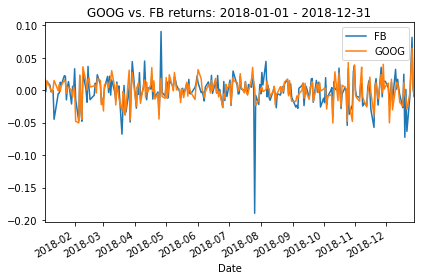

Correlation between returns: 0.62


In [33]:
adj_close = df['Adj Close']
returns = adj_close.pct_change().dropna()
plot_title = f'{" vs. ".join(RISKY_ASSETS)} returns: {START_DATE} - {END_DATE}'
returns.plot(title=plot_title)

plt.tight_layout()
plt.show()

print(f'Correlation between returns: {returns.corr().values[0,1]:.2f}')

Kovaryans matrisinin hesaplanması:

In [34]:
cov_mat = returns.cov()
cov_mat

,FB,GOOG
FB,0.000575,0.000265
GOOG,0.000265,0.000315


Kovaryans matrisinin Cholesky ayrıştırması:

In [35]:
chol_mat = np.linalg.cholesky(cov_mat)
chol_mat

array([[0.02397822, 0.        ],
       [0.01105641, 0.01389752]])

Standart Normal Dağılımdan birbiriyle korele rastgele sayıların çekilmesi:

In [36]:
rv = np.random.normal(size=(N_SIMS, len(RISKY_ASSETS)))
correlated_rv = np.transpose(np.matmul(chol_mat, np.transpose(rv)))

Simulasyon için metriklerin tanımlanması:

In [37]:
r = np.mean(returns, axis=0).values
sigma = np.std(returns, axis=0).values
S_0 = adj_close.values[-1, :]
P_0 = np.sum(SHARES * S_0)

İstenen stokların terminal fiyatlarının hesaplanması:

In [38]:
S_T = S_0 * np.exp((r - 0.5 * sigma ** 2) * T + 
                   sigma * np.sqrt(T) * correlated_rv)

Terminal portfolyo değerinin ve portfolyo getirilerinin hesaplanması:

In [39]:
P_T = np.sum(SHARES * S_T, axis=1)
P_diff = P_T - P_0

VaR hesaplanması:

In [40]:
P_diff_sorted = np.sort(P_diff)
percentiles = [0.01, 0.1, 1.]
var = np.percentile(P_diff_sorted, percentiles)

for x, y in zip(percentiles, var):
    print(f'1-day VaR with {100-x}% confidence: {-y:.2f}$')

1-day VaR with 99.99% confidence: 8.24$
1-day VaR with 99.9% confidence: 7.14$
1-day VaR with 99.0% confidence: 5.78$


Sonuçların grafikle gösterilmesi:

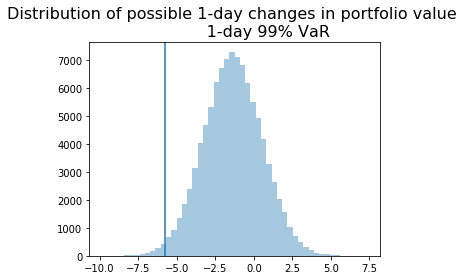

In [41]:
ax = sns.distplot(P_diff, kde=False)
ax.set_title('''Distribution of possible 1-day changes in portfolio value 
             1-day 99% VaR''', fontsize=16)
ax.axvline(var[2], 0, 10000)

plt.tight_layout()
plt.show()

Yukarıdaki grafik olası 1 gün öncesi portföy değerlerinin dağılımını göstermektedir. Riske maruz değeri dikey çizgiyle sunuyoruz.

VaR'yi farklı yaklaşımlar kullanarak hesaplamanın dezavantajları vardır, bunlardan bazıları şunlardır:
* Parametrik dağılım varsayımı (varyans-kovaryans yaklaşımı).
* Yeterli kuyruk riski yakalamamak.
* Sözde Black Swan olaylarını dikkate almamak (zaten tarihsel örnekte olmadıkları sürece).
* Tarihsel VaR, yeni piyasa koşullarına uyum sağlamakta yavaş olabilir.
* Tarihsel Simülasyon Yaklaşımı, geçmiş getirilerin gelecekteki riski değerlendirmek için yeterli olduğunu varsayar (önceki noktalara bağlanır).

RMD'nin bir diğer genel dezavantajı, RMD tarafından verilen eşiği aştığında potansiyel kaybın büyüklüğü hakkında bilgi içermemesidir. Beklenen Eksiklik (koşullu VaR veya beklenen kuyruk kaybı olarak da bilinir) devreye girer. Sadece senaryoların en kötü % X'inde beklenen kaybın ne olduğunu belirtir.

Beklenen Eksikliği hesaplamanın birçok yolu vardır, ancak burada, VaR'ye kolayca bağlı olan ve Monte Carlo kullanılarak tahmin edilebilecek olanı sunuyoruz.

İki varlıklı portföy örneğinden sonra, aşağıdakileri bilmek istiyoruz: zarar VaR'yi aşarsa, ne kadar büyük olacak? Bu sayıyı elde etmek için, VaR tarafından verilen değerden daha yüksek olan tüm kayıpları filtrelememiz ve ortalamayı alarak beklenen değerlerini hesaplamamız gerekir.

Bunu aşağıdaki kodu kullanarak yapabiliriz:

In [42]:
var = np.percentile(P_diff_sorted, 5)
expected_shortfall = P_diff_sorted[P_diff_sorted<=var].mean()

print(f'The 1-day 95% VaR is {-var:.2f}$, and the accompanying Expected Shortfall is {-expected_shortfall:.2f}$.')

The 1-day 95% VaR is 4.48$, and the accompanying Expected Shortfall is 5.27$.


Bu sonuçları şu şekilde yorumlayabiliriz: zarar %95 VaR'yi aşarsa, portföyümüzü 1 gün boyunca tutarak 5.27 dolar kaybetmeyi bekleyebiliriz.

Beklenen Eksiklik için, VaR'yi elde etmek için kullanılan tüm simülasyonların yalnızca küçük bir kısmını kullandığımızı unutmayın. Bu nedenle, Beklenen Eksiklik için makul sonuçlar elde etmek için, genel örnek yeterince büyük olmalıdır.